# Phase 6: Run Interactions

Documentation: 

In [1]:
import pandas as pd
from pathlib import Path
import igem

rpy2 ModuleSpec(name='rpy2', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f90686f8760>, origin='/home/alrico/group/personal/nikki/pbs_igem2/venv/lib/python3.10/site-packages/rpy2/__init__.py', submodule_search_locations=['/home/alrico/group/personal/nikki/pbs_igem2/venv/lib/python3.10/site-packages/rpy2'])


In [2]:
# define the path to the data folder
path = Path().resolve()
path_data = path / "data"

#### STEP 06_00: Prepare Identified Interaction Data (GE.db)

In [17]:
# Read Moldel (we need to clean interactions that is not in coluns list)
df_model = igem.epc.load.from_csv(str(path_data) + "/step_02_06_Models.csv") 
print(f"Start with: {len(df_model)} interactions")

Loaded 401,736 observations of 5 variables
Start with: 401736 interactions


In [28]:
# Keep only interactions terms
df_model = igem.epc.modify.colfilter(
    df_model,
    only=['field_name_1', 'field_name_2']
    )
df_model.reset_index(drop=True, inplace=True)  

# Order terms
df_model['Ordered_Term1'] = df_model.apply(lambda row: min(row['field_name_1'], row['field_name_2']), axis=1)
df_model['Ordered_Term2'] = df_model.apply(lambda row: max(row['field_name_1'], row['field_name_2']), axis=1)

# Remove duplicates relationship terms
df_model = df_model.drop_duplicates(subset=['Ordered_Term1', 'Ordered_Term2']).copy()
df_model.drop(columns=['Ordered_Term1', 'Ordered_Term2'], inplace=True)

df_model.rename(columns={'field_name_1': 'Term1', 'field_name_2': 'Term2'}, inplace=True)

Running colfilter
--------------------------------------------------------------------------------
Keeping 2 of 4 variables:
	0 of 0 binary variables
	0 of 0 categorical variables
	0 of 0 continuous variables
	2 of 4 unknown variables


#### STEP 06_01: Process Interactions

In [31]:
# Function to check if columns exist in DataFrame
def columns_exist(df, cols):
        return all(col in df.columns for col in cols)

In [37]:
# Define the groups
list_covariates = ['RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'BMXBMI']
list_outcomes = ['LBDLDL_N', 'LBXTC_N', 'LBXSTR', 'LBDHDL', 'LBXHDD', 'LBDHDD']

# Define columns output regression list
ls_output = ["Outcome",
    "Term1",
    "Term2",
    "Converged",
    "pvalue",
    "N",
    "Red_Var1_beta",
    "Red_Var1_SE",
    "Red_Var1_Pval",
    "Red_Var2_beta",
    "Red_Var2_SE",
    "Red_Var2_Pval",
    "Full_Var1_Var2_beta",
    "Full_Var1_Var2_SE",
    "Full_Var1_Var2_Pval",
    "Full_Var1_beta",
    "Full_Var1_SE",
    "Full_Var1_Pval",
    "Full_Var2_beta",
    "Full_Var2_SE",
    "Full_Var2_Pval",
    "Log",
    ]

In [38]:
# Interaction Regression Function
def run_interactions(df_models, df_data, outcome):
        
    list_results = []  

    for i_mappair in df_models.index:
        # get Exposomes
        e1 = df_models["Term1"][i_mappair]
        e2 = df_models["Term2"][i_mappair]

        # Check if columns exist in the DataFrame
        if columns_exist(df_data, [e1, e2]):
            # create a DataFrame with the columns of interest
            v_list = list_covariates + [outcome, e1, e2]
            df_exe = df_data.loc[:, v_list]
            print(f"Processed with: {e1} and {e2}")
        else:
            print(f"Skipped: {e1} and/or {e2} not found")
            continue

        # Drop Constants Columns
        non_constant_columns = df_exe.columns[df_exe.nunique() > 1]
        df_exe = df_exe[non_constant_columns]

        if not columns_exist(df_exe, v_list):
            continue
        if e1 == e2:
            continue

        # Run the interaction study
        Interation_Study = igem.epc.analyze.interaction_study(
            data=df_exe,
            outcomes=outcome,
            interactions=[(e1, e2)],
            covariates=list_covariates,
            report_betas=True,
            min_n=200,
        )

        # Keep the results values
        list_results.append(
            [
                Interation_Study.LRT_pvalue.index.levels[2][0],
                e1,    
                e2,
                Interation_Study.Converged.values[0],
                Interation_Study.LRT_pvalue.values[0],
                Interation_Study.N.values[0],
                Interation_Study.Red_Var1_beta.values[0],
                Interation_Study.Red_Var1_SE.values[0],
                Interation_Study.Red_Var1_Pval.values[0],
                Interation_Study.Red_Var2_beta.values[0],
                Interation_Study.Red_Var2_SE.values[0],
                Interation_Study.Red_Var2_Pval.values[0],
                Interation_Study.Full_Var1_Var2_beta.values[0],
                Interation_Study.Full_Var1_Var2_SE.values[0],
                Interation_Study.Full_Var1_Var2_Pval.values[0],
                Interation_Study.Full_Var1_beta.values[0],
                Interation_Study.Full_Var1_SE.values[0],
                Interation_Study.Full_Var1_Pval.values[0],
                Interation_Study.Full_Var2_beta.values[0],
                Interation_Study.Full_Var2_SE.values[0],
                Interation_Study.Full_Var2_Pval.values[0],
                Interation_Study.Log.values[0],
            ]
        )
    
    return list_results

In [35]:
# Loop to process each Outcome
results = []
# list_outcomes = ['LBDLDL_N'] # DEBUG ONLY
# list_outcomes = ['LBXTC_N'] # DEBUG ONLY
for outcome in list_outcomes:

    # Clean extructures to collect results
    df_results_discover_final = pd.DataFrame()
    df_results_replicate_final = pd.DataFrame()
    list_results_discover = []
    list_results_replicate = []

    # Read QC Dataset
    file_name = str(path_data) + "/step_05_05/QC_NHANES_" + outcome + ".pkl"
    df_nhanes = pd.read_pickle(file_name)

    # Define the list of exposes
    excluded_columns = set(list_covariates + list_outcomes)
    list_exposes = [col for col in df_nhanes.columns if col not in excluded_columns]

    # Keep only interactions that are in the columns of df_nhanes
    # Create a set of df_nhanes columns for quick checking
    nhanes_columns = set(df_nhanes.columns)
    # filter df_models to keep only interactions where both terms are in df_nhanes columns
    df_models_filtered = df_model[
        df_model.apply(
            lambda row: row['Term1'] in nhanes_columns and row['Term2'] in nhanes_columns, axis=1
            )
        ]
    df_models_filtered.reset_index(drop=True, inplace=True)    
    print(f"Total Interactions = {len(df_model)} / After sync = {len(df_models_filtered)}")

    # Split Dataset
    df_discovery = df_nhanes[df_nhanes['group'] == 'discovery']
    df_replicate = df_nhanes[df_nhanes['group'] == 'replication']

    # Run Interaction Analysis to Discovery Dataset
    list_results_discover = run_interactions(
        df_models_filtered,
        df_discovery,
        outcome        
    )

    # Create a DataFrame with the results
    df_results_discover = pd.DataFrame(
        list_results_discover,
        columns=ls_output,
        )
    
    # Add corrected p-values
    igem.epc.analyze.add_corrected_pvalues(df_results_discover)

    file_name = str(path_data) + "/step_06_00/Result_" + outcome + "_discovery.csv"
    df_results_discover.to_csv(file_name)

    # Filter the results to keep only significant interactions
    df_results_discover_sig = df_results_discover[
        df_results_discover['pvalue_fdr'] < 0.1
        ]


    # Start Replication Analysis
    list_results_replicate = run_interactions(
        df_results_discover_sig,
        df_replicate,
        outcome        
    )     

    # Create a DataFrame with the results
    df_results_replicate = pd.DataFrame(
        list_results_replicate,
        columns=ls_output,
        )

    # Add corrected p-values
    igem.epc.analyze.add_corrected_pvalues(df_results_replicate)

    file_name = str(path_data) + "/step_06_00/Result_" + outcome + "_replicate.csv"
    df_results_replicate.to_csv(file_name)

    print(f" ----- End Analysis to {outcome} ----- ")

print("End of Analysis")

Total Interactions = 359498 / After sync = 7855
Processed with: WHD080O and SLD010H
Processed with: WHD100O and SLD010H
Processed with: DUQ380D and SLD010H
Processed with: LBXSBU and DBQ235A
InteractionRegression
-------------------------
Continuous Outcome (family = Gaussian): 'LBDLDL_N'
Using 11,453 of 11,453 observations
Regressing 2 variables
	0 binary variables
	1 categorical variables
	1 continuous variables
	0 genotypes variables
Processing 1 interactions
-------------------------
Running 1 interactions using 56 processes...
	Finished Running 1 interactions
0 tests had an error
Completed Interaction Study for LBDLDL_N

Completed association study
Processed with: LBXSBU and DBQ235B
InteractionRegression
-------------------------
Continuous Outcome (family = Gaussian): 'LBDLDL_N'
Using 11,453 of 11,453 observations
Regressing 2 variables
	0 binary variables
	1 categorical variables
	1 continuous variables
	0 genotypes variables
Processing 1 interactions
-------------------------
R

In [16]:
len(df_models_filtered)

9357

---------------------

# DEBUG

In [8]:
# Define the groups
list_covariates = ['RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'BMXBMI']

outcome = 'LBDLDL_N'

# Clean extructures to collect results
df_results_discover_final = pd.DataFrame()
df_results_replicate_final = pd.DataFrame()
list_results_discover = []
list_results_replicate = []

# Set counts
count_lt_threshold = 0
count_no_columns = 0
count_same_e = 0

# Read QC Dataset
file_name = str(path_data) + "/step_05_05/QC_NHANES_" + outcome + ".pkl"
df_nhanes = pd.read_pickle(file_name)

# Define the list of exposes
excluded_columns = set(list_covariates + list_outcomes)
list_exposes = [col for col in df_nhanes.columns if col not in excluded_columns]

# Keep only interactions that are in the columns of df_nhanes
# Create a set of df_nhanes columns for quick checking
nhanes_columns = set(df_nhanes.columns)
# filter df_models to keep only interactions where both terms are in df_nhanes columns
df_models_filtered = df_model[df_model.apply(lambda row: row['field_name_1'] in nhanes_columns and row['field_name_2'] in nhanes_columns, axis=1)]
df_models_filtered.reset_index(drop=True, inplace=True)
print(f"Total Interactions = {len(df_model)} / After sync = {len(df_models_filtered)}")

# Split Dataset
df_discovery = df_nhanes[df_nhanes['group'] == 'discovery']
df_replicate = df_nhanes[df_nhanes['group'] == 'replication']

Total Interactions = 401736 / After sync = 9357


In [9]:
e1 = 'LBXIRN'
e2 = 'LBXSIR'

# RUN QC over Exposures Subset
# Check if columns exist in the DataFrame
if columns_exist(df_discovery, [e1, e2]):
    # create a DataFrame with the columns of interest
    v_list = list_covariates + [outcome, e1, e2]
    df_exe = df_discovery.loc[:, v_list]
    print(f"Processed with: {e1} and {e2}")
else:
    print(f"Skipped: {e1} and/or {e2} not found")

# Drop Constants Columns
non_constant_columns = df_exe.columns[df_exe.nunique() > 1]
df_exe = df_exe[non_constant_columns]

# if len(df_exe) < 200:
#     count_lt_threshold += 1
#     continue
if not columns_exist(df_exe, v_list):
    count_no_columns += 1
if e1 == e2:
    count_same_e += 1
# -- End of QC

Processed with: LBXIRN and LBXSIR


In [10]:
# Run the interaction study
Interation_Study = igem.epc.analyze.interaction_study(
    data=df_exe,
    outcomes=outcome,
    interactions=[(e1, e2)],
    covariates=list_covariates,
    report_betas=True,
    min_n=200,
)

InteractionRegression
-------------------------
Continuous Outcome (family = Gaussian): 'LBDLDL_N'
Using 11,453 of 11,453 observations
Regressing 2 variables
	0 binary variables
	0 categorical variables
	2 continuous variables
	0 genotypes variables
Processing 1 interactions
-------------------------
Running 1 interactions using 56 processes...
	Finished Running 1 interactions
0 tests had an error
Completed Interaction Study for LBDLDL_N

Completed association study


In [11]:
Interation_Study

Parameter  Converged     N    LRT_pvalue  \
Term1  Term2  Outcome                                                  
LBXIRN LBXSIR LBDLDL_N  LBXIRN:LBXSIR       True  5889  1.342654e-09   

                        Red_Var1_beta  Red_Var1_SE  Red_Var1_Pval  \
Term1  Term2  Outcome                                               
LBXIRN LBXSIR LBDLDL_N      -0.000055      0.00053       0.916545   

                        Red_Var2_beta  Red_Var2_SE  Red_Var2_Pval  \
Term1  Term2  Outcome                                               
LBXIRN LBXSIR LBDLDL_N       0.000058      0.00054       0.915113   

                        Full_Var1_Var2_beta  Full_Var1_Var2_SE  \
Term1  Term2  Outcome                                            
LBXIRN LBXSIR LBDLDL_N            -0.000009           0.000001   

                        Full_Var1_Var2_Pval  Full_Var1_beta  Full_Var1_SE  \
Term1  Term2  Outcome                                                       
LBXIRN LBXSIR LBDLDL_N         1.393001e-09        0.000883       0.00055   

                        Full_Var1_Pval  Full_Var2_beta  Full_Var2_SE  \
Term1  Term2  Outcome                                                  
LBXIRN LBXSIR LBDLDL_N        0.108422         0.00104      0.000562   

                        Full_Var2_Pval Log  
Term1  Term2  Outcome                       
LBXIRN LBXSIR LBDLDL_N        0.064346

In [16]:
# Keep the results values
list_results_discover.append(
    [
        Interation_Study.LRT_pvalue.index.levels[2][0],
        Interation_Study.LRT_pvalue.index.levels[0][0],
        Interation_Study.LRT_pvalue.index.levels[1][0],
        Interation_Study.Converged.values[0],
        Interation_Study.LRT_pvalue.values[0],
        Interation_Study.LRT_pvalue.values[0] * len(df_exe),
        Interation_Study.N.values[0],
        Interation_Study.Red_Var1_beta.values[0],
        Interation_Study.Red_Var1_SE.values[0],
        Interation_Study.Red_Var1_Pval.values[0],
        Interation_Study.Red_Var2_beta.values[0],
        Interation_Study.Red_Var2_SE.values[0],
        Interation_Study.Red_Var2_Pval.values[0],
        Interation_Study.Full_Var1_Var2_beta.values[0],
        Interation_Study.Full_Var1_Var2_SE.values[0],
        Interation_Study.Full_Var1_Var2_Pval.values[0],
        Interation_Study.Full_Var1_beta.values[0],
        Interation_Study.Full_Var1_SE.values[0],
        Interation_Study.Full_Var1_Pval.values[0],
        Interation_Study.Full_Var2_beta.values[0],
        Interation_Study.Full_Var2_SE.values[0],
        Interation_Study.Full_Var2_Pval.values[0],
        Interation_Study.Log.values[0],
    ]
)

In [17]:
# Create a DataFrame with the results
df_results_discover = pd.DataFrame(
list_results_discover,
columns=[
    "Outcome",
    "Term1",
    "Term2",
    "Converged",
    "pvalue",
    "Bonfp",
    "N",
    "Red_Var1_beta",
    "Red_Var1_SE",
    "Red_Var1_Pval",
    "Red_Var2_beta",
    "Red_Var2_SE",
    "Red_Var2_Pval",
    "Full_Var1_Var2_beta",
    "Full_Var1_Var2_SE",
    "Full_Var1_Var2_Pval",
    "Full_Var1_beta",
    "Full_Var1_SE",
    "Full_Var1_Pval",
    "Full_Var2_beta",
    "Full_Var2_SE",
    "Full_Var2_Pval",
    "Log",
    ],
)

In [18]:
df_results_discover

Outcome   Term1   Term2  Converged        pvalue         Bonfp     N  \
0  LBDHDD  LBX2DF  LBXVBZ       True  4.182423e-11  8.967952e-07  9475   

   Red_Var1_beta  Red_Var1_SE  Red_Var1_Pval  ...  Full_Var1_Var2_beta  \
0      -0.286738     0.076138       0.000167  ...             0.976924   

   Full_Var1_Var2_SE  Full_Var1_Var2_Pval  Full_Var1_beta  Full_Var1_SE  \
0           0.147991         4.296870e-11        -0.64428      0.093299   

   Full_Var1_Pval  Full_Var2_beta  Full_Var2_SE  Full_Var2_Pval  Log  
0    5.323518e-12       -0.024175      0.038311        0.528039       

[1 rows x 23 columns]

In [19]:
# Add corrected p-values
igem.epc.analyze.add_corrected_pvalues(df_results_discover)

file_name = str(path_data) + "/step_06_00/Result_" + outcome + "_discovery.csv"
df_results_discover.to_csv(file_name)

# Filter the results to keep only significant interactions
df_results_discover_sig = df_results_discover[
df_results_discover['pvalue_fdr'] < 0.1
]


In [20]:
df_results_discover_sig

Outcome   Term1   Term2  Converged        pvalue         Bonfp     N  \
0  LBDHDD  LBX2DF  LBXVBZ       True  4.182423e-11  8.967952e-07  9475   

   Red_Var1_beta  Red_Var1_SE  Red_Var1_Pval  ...  Full_Var1_Var2_Pval  \
0      -0.286738     0.076138       0.000167  ...         4.296870e-11   

   Full_Var1_beta  Full_Var1_SE  Full_Var1_Pval  Full_Var2_beta  Full_Var2_SE  \
0        -0.64428      0.093299    5.323518e-12       -0.024175      0.038311   

   Full_Var2_Pval  Log  pvalue_bonferroni    pvalue_fdr  
0        0.528039            4.182423e-11  4.182423e-11  

[1 rows x 25 columns]

In [19]:
df_exe

RIDAGEYR RIAGENDR RIDRETH1  BMXBMI    LBDHDD  LBX2DF  LBXVBZ
ID                                                                 
41475      62.0      2.0      5.0   58.04  3.850148  0.0078   0.017
41477      71.0      1.0      3.0   30.05  3.526361  0.0078   0.017
41479      52.0      1.0      1.0   27.56  3.850148     NaN     NaN
41482      64.0      1.0      1.0   33.64  3.761200  0.0078   0.017
41483      66.0      1.0      4.0   44.06  3.583519     NaN     NaN
...         ...      ...      ...     ...       ...     ...     ...
71909      28.0      1.0      1.0   29.40  3.850148  0.0430   0.080
71911      27.0      1.0      1.0   31.30  3.713572     NaN     NaN
71912      40.0      1.0      3.0   27.90  3.465736  0.0940   0.289
71913      18.0      2.0      5.0   21.60  4.110874     NaN     NaN
71915      60.0      1.0      3.0   27.50  3.583519  0.0078   0.017

[21442 rows x 7 columns]

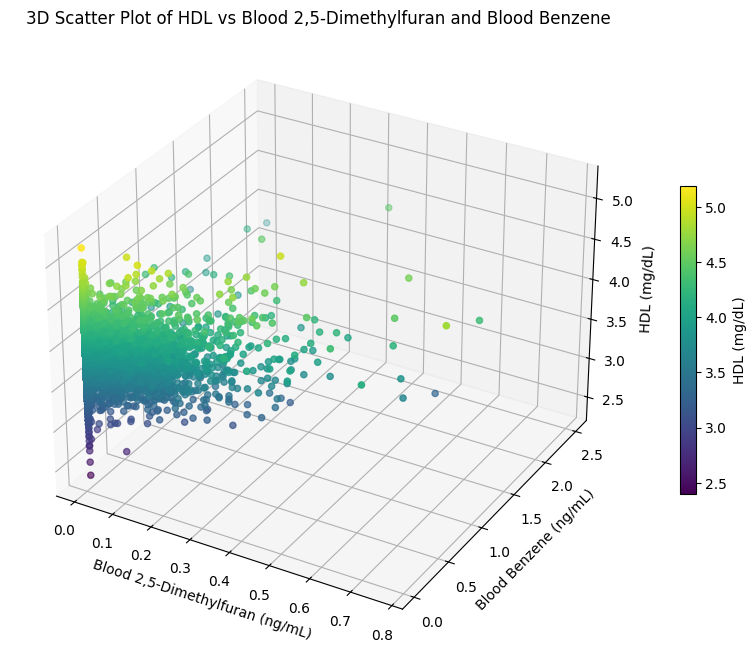

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Plot 3D para visualizar a interação
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
sc = ax.scatter(df_exe['LBX2DF'], df_exe['LBXVBZ'], df_exe['LBDHDD'], c=df_exe['LBDHDD'], cmap='viridis', marker='o')

ax.set_xlabel('Blood 2,5-Dimethylfuran (ng/mL)')
ax.set_ylabel('Blood Benzene (ng/mL)')
ax.set_zlabel('HDL (mg/dL)')
ax.set_title('3D Scatter Plot of HDL vs Blood 2,5-Dimethylfuran and Blood Benzene')

# Adicionar barra de cor
cb = plt.colorbar(sc, ax=ax, shrink=0.5)
cb.set_label('HDL (mg/dL)')

plt.show()

# # Heatmap para visualizar a interação
# plt.figure(figsize=(14, 8))
# pivot_table = df_exe.pivot_table(values='LBDHDD', index='LBXVBZ', columns='LBX2DF')
# sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt=".2f")
# plt.title('Heatmap of HDL vs Blood 2,5-Dimethylfuran and Blood Benzene')
# plt.xlabel('Blood 2,5-Dimethylfuran (ng/mL)')
# plt.ylabel('Blood Benzene (ng/mL)')
# plt.show()

In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Adicionar termos de interação ao DataFrame
df_exe['Interaction'] = df_exe['LBX2DF'] * df_exe['LBXVBZ']

# Modelo de regressão linear múltipla com termo de interação
model = ols('LBDHDD ~ LBX2DF * LBXVBZ + RIDAGEYR + RIAGENDR + RIDRETH1 + BMXBMI', data=df_exe).fit()

# Resumo do modelo
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 LBDHDD   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     248.3
Date:                Thu, 27 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:22:45   Log-Likelihood:                -659.03
No. Observations:                9475   AIC:                             1340.
Df Residuals:                    9464   BIC:                             1419.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.1522      0.015    2

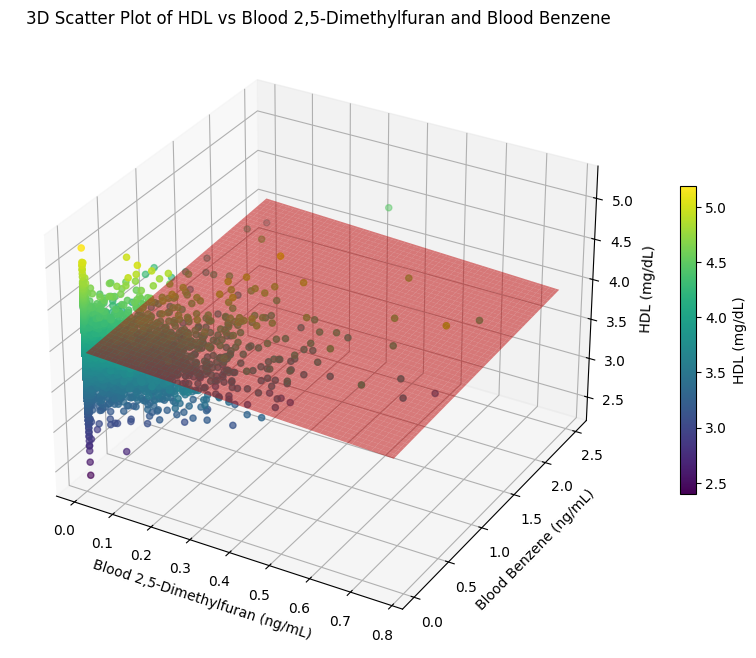

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import LinearRegression

# Supondo que df_exe seja seu DataFrame com os dados
# df_exe = pd.read_csv('path_to_your_data.csv')

# Remover linhas com valores ausentes
df_exe = df_exe.dropna(subset=['LBX2DF', 'LBXVBZ', 'LBDHDD'])


# Preparar os dados para a regressão linear
X = df_exe[['LBX2DF', 'LBXVBZ']]
y = df_exe['LBDHDD']

# Ajustar o modelo de regressão linear
reg = LinearRegression()
reg.fit(X, y)

# Prever valores de HDL ao longo de um grid de valores de LBX2DF e LBXVBZ
x_surf, y_surf = np.meshgrid(np.linspace(X['LBX2DF'].min(), X['LBX2DF'].max(), 100), np.linspace(X['LBXVBZ'].min(), X['LBXVBZ'].max(), 100))
z_surf = reg.predict(np.c_[x_surf.ravel(), y_surf.ravel()]).reshape(x_surf.shape)

# Plot 3D para visualizar a interação
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
sc = ax.scatter(df_exe['LBX2DF'], df_exe['LBXVBZ'], df_exe['LBDHDD'], c=df_exe['LBDHDD'], cmap='viridis', marker='o')

# Adicionar a superfície de tendência
ax.plot_surface(x_surf, y_surf, z_surf, color='red', alpha=0.5)

ax.set_xlabel('Blood 2,5-Dimethylfuran (ng/mL)')
ax.set_ylabel('Blood Benzene (ng/mL)')
ax.set_zlabel('HDL (mg/dL)')
ax.set_title('3D Scatter Plot of HDL vs Blood 2,5-Dimethylfuran and Blood Benzene')

# Adicionar barra de cor
cb = plt.colorbar(sc, ax=ax, shrink=0.5)
cb.set_label('HDL (mg/dL)')

plt.show()
